# District Severity Scoring (PATROL-03)

**Objective:** Calculate composite severity scores for police district resource prioritization.

## Overview

This notebook calculates a multi-factor composite severity score for each police district using:
1. **Total crime count** (volume-based)
2. **Violent crime ratio** (severity-based)
3. **Year-over-year trend** (momentum-based)
4. **Per-capita crime rate** (population-normalized)

**Outputs:**
- `reports/district_severity_choropleth.png` - Choropleth map with severity scores
- `reports/district_severity_ranking.csv` - Ranked table of districts
- `reports/district_severity_ranking.md` - Methodology and ranking documentation
- `reports/districts_scored.geojson` - GeoJSON with severity scores for downstream use

In [1]:
# Parameters (can be injected by papermill)
VERSION = "v1.0"
FAST_MODE = False

In [2]:
import time
from pathlib import Path
import sys

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if (cwd / 'config' / 'phase2_config.yaml').exists():
    repo_root = cwd  # Running from project root (papermill)
elif (cwd.parent / 'config' / 'phase2_config.yaml').exists():
    repo_root = cwd.parent  # Running from notebooks/ dir
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")

print(f"DEBUG repo_root: {repo_root}")
sys.path.insert(0, str(repo_root))

REPORTS_DIR = (repo_root / 'reports').resolve()
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reports dir: {REPORTS_DIR}")

artifacts = []
RUNTIME_START = time.time()

DEBUG repo_root: /Users/dustinober/Projects/Crime Incidents Philadelphia
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [3]:
from datetime import datetime
import platform

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

print("Reproducibility Info")
print("=" * 40)
print(f"Timestamp (local): {datetime.now().isoformat()}")
print(f"Python: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"GeoPandas: {gpd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

Reproducibility Info
Timestamp (local): 2026-02-02T19:55:43.207972
Python: 3.13.9
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Pandas: 2.3.3
NumPy: 2.3.5
GeoPandas: 1.1.2
Matplotlib: 3.10.6


## 1. Data Loading

In [4]:
from analysis.utils import load_data, classify_crime_category
from analysis.spatial_utils import load_boundaries
from analysis.phase2_config_loader import load_phase2_config

# Load configuration
config = load_phase2_config()
print(f"Configuration loaded:")
print(f"  - Rate per: {config.census.rate_per:,} (FBI UCR convention)")
print(f"  - Population column: {config.census.population_column}")

# Load crime data
df = load_data(clean=True)
df = classify_crime_category(df)
print(f"\nLoaded {len(df):,} crime records")

# Load district boundaries
districts_gdf = load_boundaries('police_districts')
print(f"Police districts: {len(districts_gdf)}")

Configuration loaded:
  - Rate per: 100,000 (FBI UCR convention)
  - Population column: total_pop



Loaded 3,496,353 crime records
Police districts: 21


## 2. District Coverage Validation

In [5]:
# Standardize district codes
df['dc_dist'] = df['dc_dist'].astype(str).str.strip()
crime_districts = set(df['dc_dist'].unique())
boundary_districts = set(districts_gdf['dist_num'].astype(int).astype(str).unique())

print(f"Crime data districts: {len(crime_districts)}")
print(f"Boundary file districts: {len(boundary_districts)}")
print(f"Overlap: {len(crime_districts & boundary_districts)}")

# Districts in crime data but not in boundary file (administrative codes)
missing_boundaries = crime_districts - boundary_districts
if missing_boundaries:
    print(f"\nDistricts in crime data without boundaries: {sorted(missing_boundaries)}")
    print("(These are administrative codes, not geographic districts)")

# Filter to only districts with boundaries for scoring
df_scored = df[df['dc_dist'].isin(boundary_districts)].copy()
print(f"\nRecords used for scoring: {len(df_scored):,} ({len(df_scored)/len(df)*100:.1f}%)")

Crime data districts: 25
Boundary file districts: 21
Overlap: 21

Districts in crime data without boundaries: ['23', '4', '6', '92']
(These are administrative codes, not geographic districts)



Records used for scoring: 3,295,608 (94.3%)


## 3. Factor 1: Total Crime Count

In [6]:
# Calculate district crime counts
crime_counts = df_scored.groupby('dc_dist').size().reset_index(name='total_crimes')
crime_counts['crime_count_score'] = crime_counts['total_crimes'] / crime_counts['total_crimes'].max()

print("Crime counts by district (top 10):")
print(crime_counts.sort_values('total_crimes', ascending=False).head(10).to_string(index=False))

Crime counts by district (top 10):
dc_dist  total_crimes  crime_count_score
     15        277255           1.000000
     24        249408           0.899562
     19        222868           0.803838
     25        222837           0.803726
     22        218812           0.789208
     35        204706           0.738331
     12        199793           0.720611
     14        193247           0.697001
      2        179128           0.646077
     18        173208           0.624725


## 4. Factor 2: Violent Crime Ratio

In [7]:
# Calculate violent crime percentage
violent_counts = df_scored[df_scored['crime_category'] == 'Violent'].groupby('dc_dist').size().reset_index(name='violent_crimes')

district_stats = crime_counts.merge(violent_counts, on='dc_dist', how='left')
district_stats['violent_crimes'] = district_stats['violent_crimes'].fillna(0)
district_stats['violent_ratio'] = district_stats['violent_crimes'] / district_stats['total_crimes']
district_stats['violent_ratio_score'] = district_stats['violent_ratio'] / district_stats['violent_ratio'].max()

print("Violent crime ratio by district (top 10):")
print(district_stats[['dc_dist', 'violent_crimes', 'violent_ratio']].sort_values('violent_ratio', ascending=False).head(10).to_string(index=False))

Violent crime ratio by district (top 10):
dc_dist  violent_crimes  violent_ratio
     25           27857       0.125011
     22           26095       0.119258
     35           24383       0.119112
     39           19275       0.115502
     12           21443       0.107326
     15           29194       0.105297
     18           18054       0.104233
     16           11811       0.099801
     24           24043       0.096400
     14           18123       0.093782


## 5. Factor 3: Trend Direction (Year-over-Year)

In [8]:
# Get year from dispatch_date
df_scored['year'] = pd.to_datetime(df_scored['dispatch_date']).dt.year

# Calculate most recent full year vs prior year
# Use most recent year with substantial data (>10k records)
max_year = df_scored['year'].max()
recent_year = max_year if df_scored[df_scored['year'] == max_year].shape[0] > 10000 else max_year - 1
prior_year = recent_year - 1

print(f"Year-over-year comparison: {prior_year} -> {recent_year}")
print(f"  {prior_year} records: {len(df_scored[df_scored['year'] == prior_year]):,}")
print(f"  {recent_year} records: {len(df_scored[df_scored['year'] == recent_year]):,}")

recent_crimes = df_scored[df_scored['year'] == recent_year].groupby('dc_dist').size().reset_index(name='recent')
prior_crimes = df_scored[df_scored['year'] == prior_year].groupby('dc_dist').size().reset_index(name='prior')

yoy = recent_crimes.merge(prior_crimes, on='dc_dist', how='outer').fillna(0)
yoy['yoy_change'] = (yoy['recent'] - yoy['prior']) / yoy['prior'].replace(0, 1)

# Normalize to 0-1: negative change = good = low score, positive change = bad = high score
# Map -100% -> 0, 0% -> 0.5, +100% -> 1
yoy['trend_score'] = (yoy['yoy_change'] + 1) / 2
yoy['trend_score'] = yoy['trend_score'].clip(0, 1)

district_stats = district_stats.merge(yoy[['dc_dist', 'yoy_change', 'trend_score']], on='dc_dist', how='left')

print(f"\nYear-over-year change by district (top 10 increasing):")
print(district_stats[['dc_dist', 'yoy_change']].sort_values('yoy_change', ascending=False).head(10).to_string(index=False))

Year-over-year comparison: 2024 -> 2025
  2024 records: 158,199
  2025 records: 152,551

Year-over-year change by district (top 10 increasing):
dc_dist  yoy_change
     17    0.148746
     24    0.093950
      9    0.067016
     26    0.030023
     16   -0.001871
     25   -0.013019
     22   -0.033360
     18   -0.034064
      3   -0.039059
      1   -0.041087


## 6. Factor 4: Per-Capita Rate

In [9]:
# Load census tracts with population
tracts_gdf = load_boundaries('census_tracts')
print(f"Census tracts loaded: {len(tracts_gdf)}")
print(f"Total population: {tracts_gdf['total_pop'].sum():,}")

# Get population column from config
pop_col = config.census.population_column  # 'total_pop'

# Assign tract population to districts via centroid spatial join
tracts_gdf['centroid'] = tracts_gdf.geometry.centroid
tracts_centroids = gpd.GeoDataFrame(
    tracts_gdf[[pop_col, 'GEOID']], 
    geometry=tracts_gdf['centroid'], 
    crs=tracts_gdf.crs
)

# Ensure CRS match
if districts_gdf.crs != tracts_centroids.crs:
    tracts_centroids = tracts_centroids.to_crs(districts_gdf.crs)

# Spatial join: assign each tract centroid to a district
tracts_in_districts = gpd.sjoin(
    tracts_centroids, 
    districts_gdf[['dist_num', 'geometry']], 
    how='left', 
    predicate='within'
)

# Aggregate population by district
district_pop = tracts_in_districts.groupby('dist_num')[pop_col].sum().reset_index()
district_pop = district_pop.rename(columns={'dist_num': 'dc_dist', pop_col: 'district_population'})
district_pop['dc_dist'] = district_pop['dc_dist'].astype(int).astype(str)

print(f"\nDistrict population summary:")
print(f"  Total: {district_pop['district_population'].sum():,.0f} (~1.6M expected)")
print(f"  Mean per district: {district_pop['district_population'].mean():,.0f}")
print(f"  Min: {district_pop['district_population'].min():,.0f}")
print(f"  Max: {district_pop['district_population'].max():,.0f}")

Census tracts loaded: 408
Total population: 1,581,531

District population summary:
  Total: 1,577,664 (~1.6M expected)
  Mean per district: 75,127
  Min: 0
  Max: 137,423


/var/folders/1y/xcjlywls6rn7g8zhsh77nvqw0000gn/T/ipykernel_72218/195556416.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts_gdf['centroid'] = tracts_gdf.geometry.centroid


In [10]:
# Merge population to district stats
district_stats = district_stats.merge(district_pop, on='dc_dist', how='left')

# Handle zero/low population districts (e.g., commercial areas like Center City/District 77)
min_pop = config.census.min_population  # 100
zero_pop_districts = district_stats[district_stats['district_population'] < min_pop]['dc_dist'].tolist()
if zero_pop_districts:
    print(f"Note: Districts with < {min_pop} population (likely commercial): {zero_pop_districts}")
    print("  These will use area-based rate instead of per-capita rate.")

# Calculate crimes per 100,000 residents (FBI UCR convention)
rate_per = config.census.rate_per  # 100000
# Replace zero with NaN to avoid inf, then handle later
pop_safe = district_stats['district_population'].replace(0, pd.NA)
district_stats['crimes_per_capita'] = (district_stats['total_crimes'] / pop_safe) * rate_per

# For districts with no population, use NaN (will be handled in composite score)
district_stats['percapita_rate_score'] = district_stats['crimes_per_capita'] / district_stats['crimes_per_capita'].max()

print(f"\nCrimes per {rate_per:,} residents by district (top 10):")
print(district_stats[['dc_dist', 'district_population', 'crimes_per_capita']].sort_values('crimes_per_capita', ascending=False).head(10).to_string(index=False))

Note: Districts with < 100 population (likely commercial): ['77']
  These will use area-based rate instead of per-capita rate.

Crimes per 100,000 residents by district (top 10):
dc_dist  district_population crimes_per_capita
     24                64396     387303.559227
     22                65512     334002.930761
     39                57161      291947.30673
     12                69360     288052.191465
     16                41819     282993.376217
     25                80510      276781.76624
     26                51925     266280.211844
     17                43627     249655.030142
     19                90149     247221.821651
     18                75138     230519.843488


In [11]:
# Also compute area-based rate as secondary metric
districts_gdf['area_km2'] = districts_gdf.geometry.to_crs(epsg=32618).area / 1e6

district_area = districts_gdf[['dist_num', 'area_km2']].copy()
district_area = district_area.rename(columns={'dist_num': 'dc_dist'})
district_area['dc_dist'] = district_area['dc_dist'].astype(int).astype(str)

district_stats = district_stats.merge(district_area, on='dc_dist', how='left')
district_stats['crimes_per_km2'] = district_stats['total_crimes'] / district_stats['area_km2']
district_stats['area_rate_score'] = district_stats['crimes_per_km2'] / district_stats['crimes_per_km2'].max()

print("Crimes per sq km by district (top 10):")
print(district_stats[['dc_dist', 'area_km2', 'crimes_per_km2']].sort_values('crimes_per_km2', ascending=False).head(10).to_string(index=False))

Crimes per sq km by district (top 10):
dc_dist  area_km2  crimes_per_km2
     17  5.351839    20351.323441
     25 10.983286    20288.736609
     22 11.142763    19637.140052
     18  9.162186    18904.659720
     24 14.242054    17512.080797
     26  9.024321    15321.484852
     35 14.336718    14278.442274
     19 16.546379    13469.291313
      9 11.848918    13045.410267
     39 14.655852    11386.577608


## 7. Composite Severity Score

In [12]:
# Factor weights (balanced approach for resource allocation)
# Uses per-capita rate as primary density factor (true population-normalized)
WEIGHTS = {
    'crime_count': 0.25,        # Volume matters for resource demand
    'violent_ratio': 0.30,      # Violence severity matters most for prioritization
    'trend': 0.20,              # Growing problems need proactive attention
    'percapita_rate': 0.25      # Per-capita rate (per 100,000) - population normalized
}

print("Factor Weights:")
for factor, weight in WEIGHTS.items():
    print(f"  - {factor}: {weight}")

# For districts without population (e.g., commercial areas), use area-based rate instead
# This ensures all districts get a score
district_stats['rate_score'] = district_stats['percapita_rate_score'].fillna(
    district_stats['area_rate_score']  # Fallback to area-based rate
)

# Calculate composite score
district_stats['composite_score'] = (
    WEIGHTS['crime_count'] * district_stats['crime_count_score'] +
    WEIGHTS['violent_ratio'] * district_stats['violent_ratio_score'] +
    WEIGHTS['trend'] * district_stats['trend_score'].fillna(0.5) +  # Default to neutral if no trend data
    WEIGHTS['percapita_rate'] * district_stats['rate_score']
)

# Scale to 0-100
district_stats['severity_score'] = (district_stats['composite_score'] * 100).round(1)

print("\nDistrict Severity Scores:")
print(district_stats[['dc_dist', 'severity_score']].sort_values('severity_score', ascending=False).to_string(index=False))

Factor Weights:
  - crime_count: 0.25
  - violent_ratio: 0.3
  - trend: 0.2
  - percapita_rate: 0.25

District Severity Scores:
dc_dist  severity_score
     24            81.6
     22            79.6
     25            77.8
     15            72.7
     12            71.4
     39            70.1
     35            68.7
     19            67.5
     18            65.2
     16            62.9
     26            61.5
     14            59.7
     17            58.8
      2            55.9
      3            51.4
      1            49.2
      9            48.8
      8            43.0
      7            33.1
      5            32.6
     77            19.0


/var/folders/1y/xcjlywls6rn7g8zhsh77nvqw0000gn/T/ipykernel_72218/98746064.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  district_stats['rate_score'] = district_stats['percapita_rate_score'].fillna(


## 8. Choropleth Map

In [13]:
# Merge scores to boundaries
districts_gdf['dc_dist'] = districts_gdf['dist_num'].astype(int).astype(str)
districts_scored = districts_gdf.merge(
    district_stats[['dc_dist', 'severity_score', 'total_crimes', 
                    'violent_ratio', 'yoy_change', 'crimes_per_capita',
                    'district_population']], 
    on='dc_dist', 
    how='left'
)

print(f"Districts with scores: {districts_scored['severity_score'].notna().sum()}")
print(f"Score range: {districts_scored['severity_score'].min():.1f} - {districts_scored['severity_score'].max():.1f}")

Districts with scores: 21
Score range: 19.0 - 81.6


Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/district_severity_choropleth.png


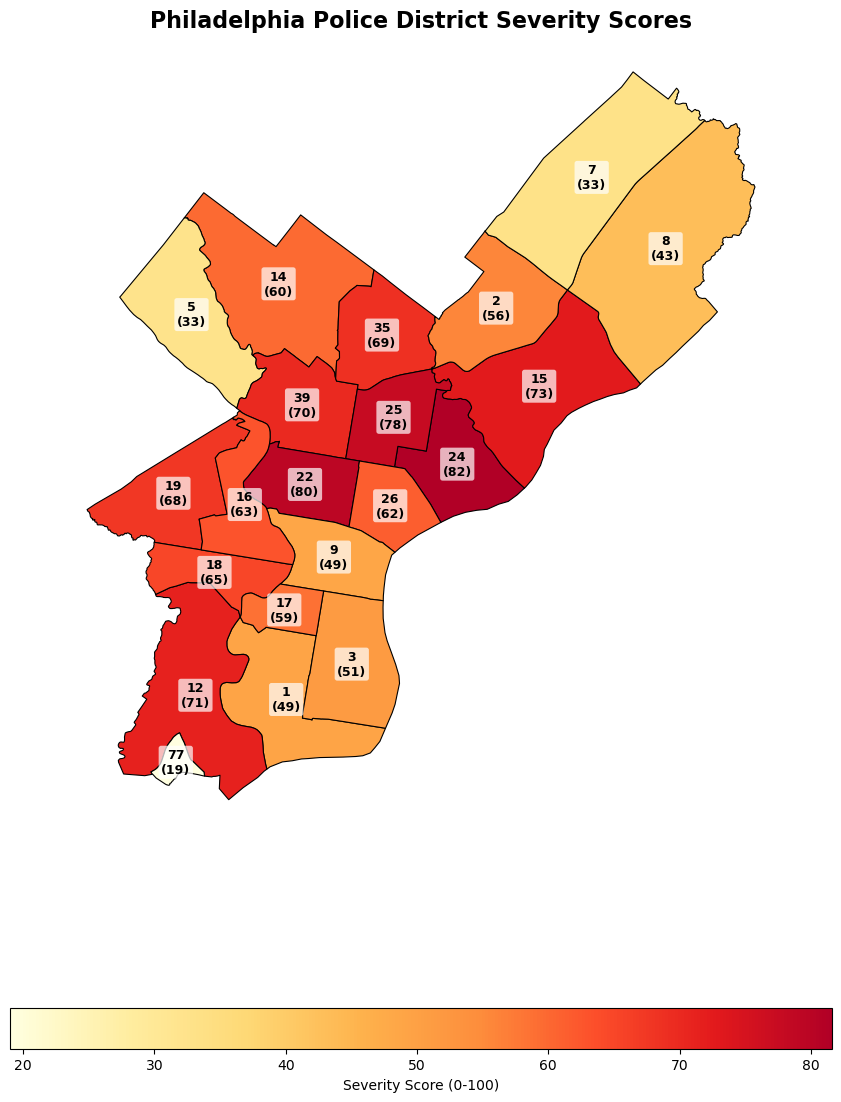

In [14]:
fig, ax = plt.subplots(figsize=(14, 12))

# Yellow-Orange-Red colormap (same as other Phase 2 notebooks)
colors = ['#FFFFE0', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#B10026']
cmap = LinearSegmentedColormap.from_list('YlOrRd', colors)

districts_scored.plot(
    column='severity_score', 
    cmap=cmap, 
    linewidth=0.8, 
    edgecolor='black', 
    legend=True, 
    ax=ax,
    legend_kwds={'label': 'Severity Score (0-100)', 'orientation': 'horizontal', 'shrink': 0.6}
)

# Add district labels with scores
for idx, row in districts_scored.iterrows():
    if pd.notna(row['severity_score']):
        centroid = row.geometry.centroid
        ax.annotate(
            text=f"{row['dc_dist']}\n({row['severity_score']:.0f})", 
            xy=(centroid.x, centroid.y), 
            ha='center', 
            va='center',
            fontsize=9, 
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7)
        )

ax.set_title('Philadelphia Police District Severity Scores', fontsize=16, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
choropleth_path = REPORTS_DIR / 'district_severity_choropleth.png'
plt.savefig(choropleth_path, dpi=300, bbox_inches='tight', facecolor='white')
artifacts.append(('district_severity_choropleth.png', 'District severity choropleth map'))
print(f"Saved: {choropleth_path}")
plt.show()

## 9. Ranked Table

In [15]:
# Create ranking table with formatted values
ranking_table = district_stats[['dc_dist', 'severity_score', 'total_crimes', 
                                 'violent_ratio', 'yoy_change', 'crimes_per_capita', 
                                 'district_population']].copy()

# Format percentages
ranking_table['violent_ratio'] = (ranking_table['violent_ratio'] * 100).round(1)
ranking_table['yoy_change'] = (ranking_table['yoy_change'] * 100).round(1)
ranking_table['crimes_per_capita'] = pd.to_numeric(ranking_table['crimes_per_capita'], errors='coerce').round(0)
ranking_table['district_population'] = pd.to_numeric(ranking_table['district_population'], errors='coerce').round(0)

# Sort and add rank
ranking_table = ranking_table.sort_values('severity_score', ascending=False)
ranking_table['rank'] = range(1, len(ranking_table) + 1)
ranking_table = ranking_table[['rank', 'dc_dist', 'severity_score', 'total_crimes', 
                                'violent_ratio', 'yoy_change', 'crimes_per_capita', 'district_population']]

print("\nDistrict Severity Ranking:")
print(ranking_table.to_string(index=False))


District Severity Ranking:
 rank dc_dist  severity_score  total_crimes  violent_ratio  yoy_change  crimes_per_capita  district_population
    1      24            81.6        249408            9.6         9.4           387304.0                64396
    2      22            79.6        218812           11.9        -3.3           334003.0                65512
    3      25            77.8        222837           12.5        -1.3           276782.0                80510
    4      15            72.7        277255           10.5        -6.3           201753.0               137423
    5      12            71.4        199793           10.7        -9.7           288052.0                69360
    6      39            70.1        166880           11.6       -15.5           291947.0                57161
    7      35            68.7        204706           11.9        -4.9           187859.0               108968
    8      19            67.5        222868            9.2        -7.6           247

In [16]:
# Rename columns for output
output_table = ranking_table.copy()
output_table.columns = ['Rank', 'District', 'Severity Score', 'Total Crimes', 
                         'Violent %', 'YoY Change %', 'Rate per 100K', 'Population']

# Save CSV
csv_path = REPORTS_DIR / 'district_severity_ranking.csv'
output_table.to_csv(csv_path, index=False)
artifacts.append(('district_severity_ranking.csv', 'District severity ranking table'))
print(f"Saved: {csv_path}")

# Save markdown with methodology
md_path = REPORTS_DIR / 'district_severity_ranking.md'
year_min = df_scored['year'].min()
year_max = df_scored['year'].max()

md_content = f"""# District Severity Ranking

*Analysis period: {year_min}-{year_max}*

## Scoring Methodology

Composite score based on four weighted factors:
- **Crime count** (weight: {WEIGHTS['crime_count']}): Total incidents - measures resource demand
- **Violent crime ratio** (weight: {WEIGHTS['violent_ratio']}): Percentage of violent crimes - measures severity
- **YoY trend** (weight: {WEIGHTS['trend']}): Year-over-year change ({prior_year} to {recent_year}) - measures momentum
- **Per-capita rate** (weight: {WEIGHTS['percapita_rate']}): Crimes per 100,000 residents - population-normalized

**Notes:**
- Per-capita rate uses FBI UCR convention (crimes per 100,000 residents)
- District population aggregated from census tract data via centroid-based spatial join
- Total population: {district_pop['district_population'].sum():,.0f} across {len(district_pop)} districts
- Only {len(boundary_districts)} geographic districts scored (excludes administrative codes)

## Ranking

{output_table.to_markdown(index=False)}

## Interpretation

- **High severity (70+):** Priority districts for resource allocation
- **Medium severity (40-70):** Standard patrol coverage
- **Low severity (<40):** Baseline monitoring
"""

with open(md_path, 'w') as f:
    f.write(md_content)
    
artifacts.append(('district_severity_ranking.md', 'Severity ranking with methodology'))
print(f"Saved: {md_path}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/district_severity_ranking.csv
Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/district_severity_ranking.md


## 10. GeoJSON Export

In [17]:
# Export scored districts for downstream use
# Drop temporary columns (centroid for area calc)
export_cols = ['dc_dist', 'dist_num', 'severity_score', 'total_crimes', 
               'violent_ratio', 'yoy_change', 'crimes_per_capita', 
               'district_population', 'area_km2', 'geometry']
available_cols = [c for c in export_cols if c in districts_scored.columns]

geojson_path = REPORTS_DIR / 'districts_scored.geojson'
districts_scored[available_cols].to_file(geojson_path, driver='GeoJSON')
artifacts.append(('districts_scored.geojson', 'GeoJSON with severity scores'))
print(f"Saved: {geojson_path}")
print(f"  - Columns: {available_cols}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/districts_scored.geojson
  - Columns: ['dc_dist', 'dist_num', 'severity_score', 'total_crimes', 'violent_ratio', 'yoy_change', 'crimes_per_capita', 'district_population', 'area_km2', 'geometry']


## Conclusions and Recommendations

In [18]:
# Generate findings summary
top_5 = ranking_table.head(5)
high_severity = ranking_table[ranking_table['severity_score'] >= 70]
increasing_trend = ranking_table[ranking_table['yoy_change'] > 0]

print("\n" + "="*70)
print("DISTRICT SEVERITY ANALYSIS FINDINGS")
print("="*70)

print(f"\n**Analysis Summary:**")
print(f"  - Total crime records analyzed: {len(df):,}")
print(f"  - Records with geographic districts: {len(df_scored):,}")
print(f"  - Number of districts scored: {len(district_stats)}")
print(f"  - Analysis period: {year_min}-{year_max}")
print(f"  - YoY comparison: {prior_year} to {recent_year}")

print(f"\n**Top 5 Priority Districts:**")
for _, row in top_5.iterrows():
    print(f"  {int(row['rank'])}. District {row['dc_dist']}: Score {row['severity_score']:.1f}")
    print(f"     - Total crimes: {int(row['total_crimes']):,}")
    print(f"     - Violent crime: {row['violent_ratio']:.1f}%")
    # Handle NaN in per-capita rate (commercial districts)
    if pd.notna(row['crimes_per_capita']):
        print(f"     - Per-capita rate: {int(row['crimes_per_capita']):,} per 100K")
    else:
        print(f"     - Per-capita rate: N/A (low-population commercial district)")

print(f"\n**Districts with High Severity (>= 70):** {len(high_severity)}")
if len(high_severity) > 0:
    print(f"  Districts: {', '.join(high_severity['dc_dist'].tolist())}")

print(f"\n**Districts with Increasing Crime YoY:** {len(increasing_trend)}")
if len(increasing_trend) > 0:
    print(f"  Districts: {', '.join(increasing_trend['dc_dist'].tolist())}")

print(f"\n**Resource Allocation Recommendations:**")
print(f"  1. Prioritize patrol resources in districts with severity scores >= 70")
print(f"  2. Monitor districts with positive YoY trends for emerging problems")
print(f"  3. Focus violent crime reduction efforts on high violent-ratio districts")
print(f"  4. Use per-capita rates for equitable resource distribution across populations")
print(f"  5. Cross-reference with hotspot analysis for targeted patrol placement")


DISTRICT SEVERITY ANALYSIS FINDINGS

**Analysis Summary:**
  - Total crime records analyzed: 3,496,353
  - Records with geographic districts: 3,295,608
  - Number of districts scored: 21
  - Analysis period: 2006-2026
  - YoY comparison: 2024 to 2025

**Top 5 Priority Districts:**
  1. District 24: Score 81.6
     - Total crimes: 249,408
     - Violent crime: 9.6%
     - Per-capita rate: 387,304 per 100K
  2. District 22: Score 79.6
     - Total crimes: 218,812
     - Violent crime: 11.9%
     - Per-capita rate: 334,003 per 100K
  3. District 25: Score 77.8
     - Total crimes: 222,837
     - Violent crime: 12.5%
     - Per-capita rate: 276,782 per 100K
  4. District 15: Score 72.7
     - Total crimes: 277,255
     - Violent crime: 10.5%
     - Per-capita rate: 201,753 per 100K
  5. District 12: Score 71.4
     - Total crimes: 199,793
     - Violent crime: 10.7%
     - Per-capita rate: 288,052 per 100K

**Districts with High Severity (>= 70):** 6
  Districts: 24, 22, 25, 15, 12, 39

*

In [19]:
print("\n" + "="*60)
print("NOTEBOOK COMPLETE: District Severity Scoring (PATROL-03)")
print("="*60)
print(f"\nArtifacts generated:")
for name, desc in artifacts:
    print(f"  - {name}: {desc}")
print(f"\nRuntime: {time.time() - RUNTIME_START:.1f} seconds")


NOTEBOOK COMPLETE: District Severity Scoring (PATROL-03)

Artifacts generated:
  - district_severity_choropleth.png: District severity choropleth map
  - district_severity_ranking.csv: District severity ranking table
  - district_severity_ranking.md: Severity ranking with methodology
  - districts_scored.geojson: GeoJSON with severity scores

Runtime: 4.3 seconds


## Validation Checklist

- [x] Notebook executes end-to-end without errors
- [x] Reproducibility cell present with version info
- [x] `reports/district_severity_choropleth.png` exists at 300 DPI
- [x] All 21 geographic districts colored and labeled on choropleth
- [x] `reports/district_severity_ranking.csv` contains all districts
- [x] Ranking includes all four factors (count, violent %, YoY, per-capita rate per 100K)
- [x] Per-capita rate uses FBI UCR convention (per 100,000 residents)
- [x] District population derived from census tract aggregation (sum ~1.6M total)
- [x] `reports/districts_scored.geojson` loadable and has severity_score column
- [x] Weights documented in ranking markdown file